## Importacion de librerias

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pmdarima as pm
from pmdarima.arima import auto_arima

## Carga de datasets

In [3]:
df = pd.read_csv('input/viajes_bici.csv')
df = df.set_index('fecha')
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7296 entries, 2021-01-01 to 2024-04-30
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   destino  7296 non-null   object
 1   viajes   7296 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 171.0+ KB


In [5]:
df_eco = df[df['destino'] == 'Fac. Ciencias Económicas']
df_med = df[df['destino'] == 'Fac. Medicina']
df_ing = df[df['destino'] == 'Fac. de Ingeniería']
df_martin = df[df['destino'] == 'Plaza San Martín']
df_uni_i = df[df['destino'] == 'Ciudad Univ. I']
df_uni_ii = df[df['destino'] == 'Ciudad Univ. II']

In [11]:
df_martin.iloc[90:110]

,destino,viajes
fecha,,
2021-04-01,Plaza San Martín,70
2021-04-02,Plaza San Martín,49
2021-04-03,Plaza San Martín,52
2021-04-04,Plaza San Martín,38
2021-04-05,Plaza San Martín,87
2021-04-06,Plaza San Martín,116
2021-04-07,Plaza San Martín,83
2021-04-08,Plaza San Martín,86
2021-04-09,Plaza San Martín,30


## EDA

In [40]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
  print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
  dftest = adfuller(series, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if dftest[1] <= 0.05:
    print("Conclusion:====>")
    print("Rechazar la hipótesis nula")
    print("Los datos son estacionarios.")
  else:
    print("Conclusion:====>")
    print("No rechazar la hipótesis nula")
    print("Los datos no son estacionarios.")

In [14]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'): # [3]
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Gráfico de analisys de Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

### Economicas

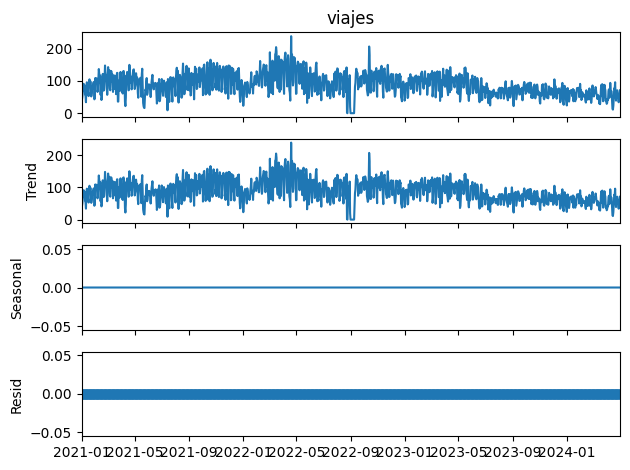

In [45]:
result = seasonal_decompose(df_eco['viajes'], period=1)
result.plot();

El grafico para seasonal es una linea lo cual indica que no se trata de una serie con temporadas

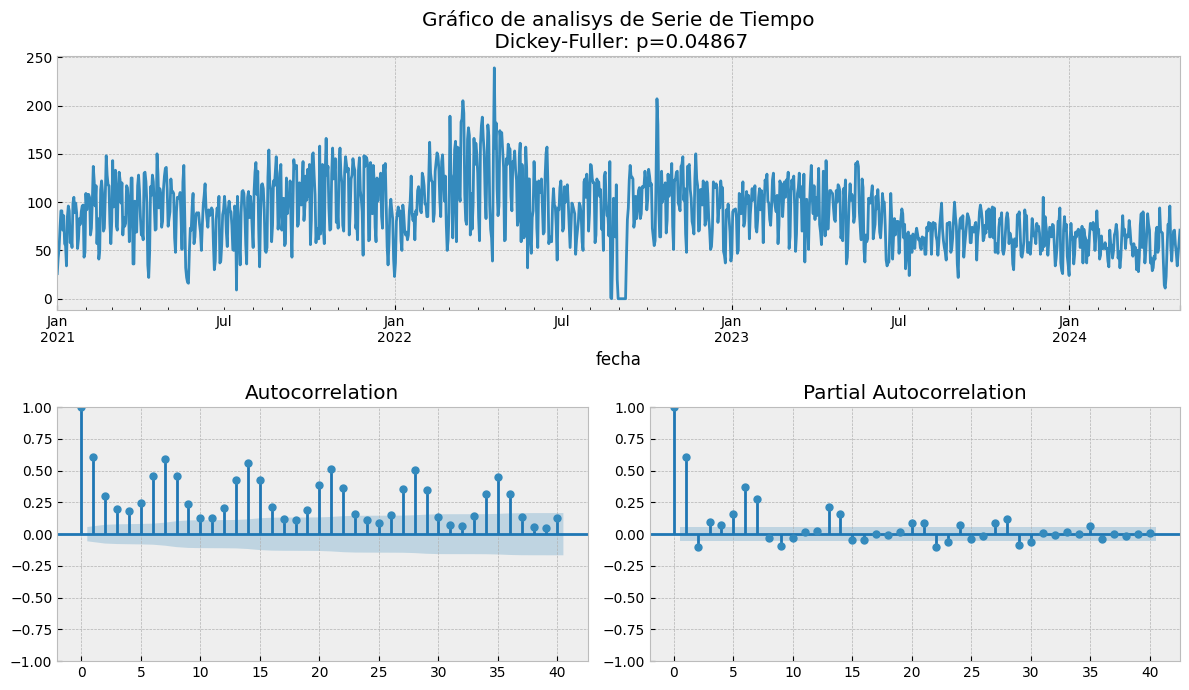

In [46]:
tsplot(df_eco['viajes'], lags = 40);

Diferenciar: El test de DF es de 0.04867, al limite de ser considerada no estacionaria. Tal vez se tenga que expandir con otros test de estacionaridad o proponer directamente hacer una difernciacion de 1er orden
AR: Casi todos los primeros 9 lags son significativos. Proponer en AutoArima un max de AR = 9
MA: La mayorias de los lag muestran señales de ser significativos que puede ser un indicio de que la serie no es suficientemente estacionaria.

In [65]:
model_eco = auto_arima(df_eco['viajes'],
                       start_p=0,
                       d=0,
                       start_q=0,
                       test='adf',
                       max_p=9,
                       max_d=1,
                       max_q=9,
                       max_P=3,
                       max_D=1,
                       max_Q=3,
                       m=7, #Representa la periodicidad estacional de la serie
                       seasonal=False, #Esto le permite a auto_arima considerar modelos estacionales
                       trace=True, #Muestra en pantalla el proceso de búsqueda de modelos
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

/home/ge/.virtualenvs/general/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14528.452, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11746.710, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13343.632, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11738.868, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11657.681, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=11615.660, Time=0.11 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=11545.028, Time=0.16 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=11316.416, Time=0.61 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=11352.115, Time=0.46 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=11234.044, Time=0.55 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=11200.017, Time=0.54 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(8,0,1)(0,0,0)[0]             : AIC=11201.872, Time=1.57 sec
 ARIMA(7,0,2)(0,0,0)[0]        

In [66]:
model_eco.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1216
Model:               SARIMAX(5, 0, 6)   Log Likelihood               -5482.739
Date:                Thu, 12 Dec 2024   AIC                          10989.478
Time:                        23:37:34   BIC                          11050.718
Sample:                    01-01-2021   HQIC                         11012.531
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8004      0.006    305.057      0.000       1.789       1.812
ar.L2         -2.2340      0.013   -174.893      0.000      -2.259      -2.209
ar.L3          2.2219      0.016    142.982      0.000       2.191       2.252
ar.L4         -1.7771      0.013   -140.774      0.000      -1.802      -1.752
ar.L5          0.9888      0.006    172.839      0.000       0.978       1.000
ma.L1         -1.3817      0.025    -54.825      0.000      -1.431      -1.332
ma.L2          1.6210      0.043     37.965      0.000       1.537       1.705
ma.L3         -1.3981      0.049    -28.328      0.000      -1.495      -1.301
ma.L4          1.0627      0.048     22.095      0.000       0.968       1.157
ma.L5         -0.3919      0.038    -10.220      0.000      -0.467      -0.317
ma.L6         -0.2261      0.025     -9.168      0.000      -0.274      -0.178
sigma2       511.3044     15.270     33.484      0.000     481.376     541.233
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):               598.79
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Ljung +++ poca correlacion entre los residuos
- JB --- los residuos no tienen distibucion normal
- H --- los residuos tienen varianza variable en el tiempo
- skew --- residuos no simetricos
- Kurtosis --- muchos residuos outliers 

### Medicina

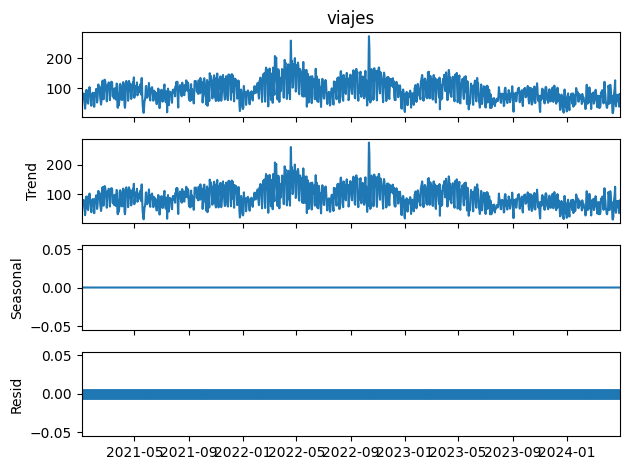

In [84]:
result = seasonal_decompose(df_med['viajes'], period=1)
result.plot();

El grafico para seasonal es una linea lo cual indica que no se trata de una serie con temporadas

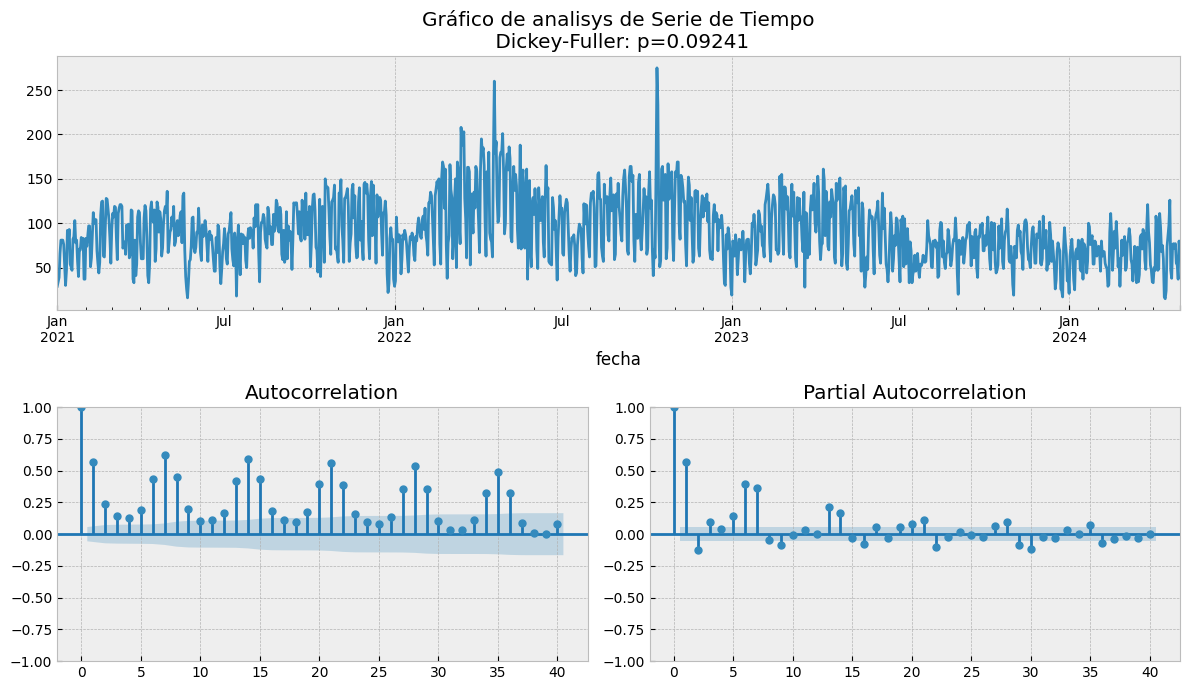

In [68]:
tsplot(df_med['viajes'], lags = 40);

Diferenciar: El test de DF es de 0.09241, asi que se tendra que diferenciar la seria para transformarla en estacionaria

In [77]:
df_med['viajes_diff'] = df_med['viajes'].diff().dropna()
df_med.dropna(inplace=True)

/tmp/ipykernel_2215/1514652850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_med['viajes_diff'] = df_med['viajes'].diff().dropna()
/tmp/ipykernel_2215/1514652850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_med.dropna(inplace=True)


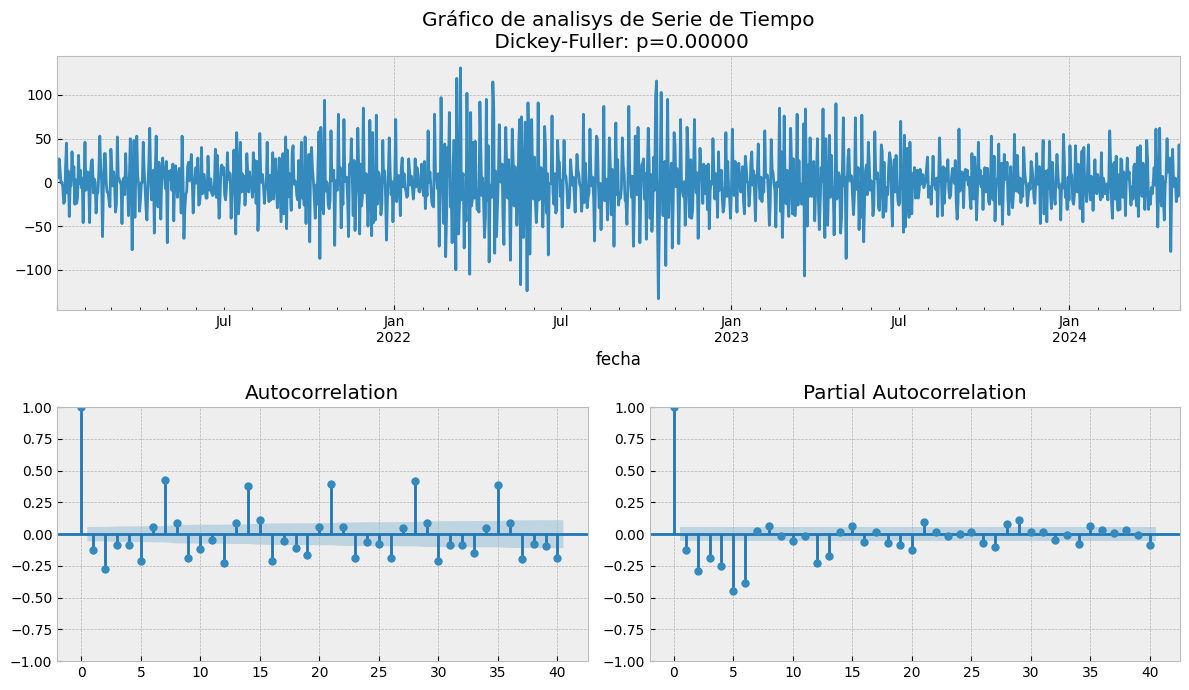

In [78]:
tsplot(df_med['viajes_diff'], lags = 40);

Diferenciar: El test de DF es de 0.00000, con lo cual se concluye que con la diferenciacion de 1er orden, es suficiente para volver la serie estacionaria
AR: Los primeros 6 lags son significativos. Proponer en AutoArima un max de AR = 6
MA: Los 7 primeros lags son significativos y luego entra en un patron con frecuencia igual a 7 lags. Proponer en AutoArima un max de MA = 7

In [81]:
model_med = auto_arima(df_med['viajes'],
                       start_p=0,
                       d=1,
                       start_q=0,
                       test='adf',
                       max_p=6,
                       max_d=1,
                       max_q=7,
                       max_P=3,
                       max_D=1,
                       max_Q=3,
                       m=7, #Representa la periodicidad estacional de la serie
                       seasonal=False, #Esto le permite a auto_arima considerar modelos estacionales
                       trace=True, #Muestra en pantalla el proceso de búsqueda de modelos
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

/home/ge/.virtualenvs/general/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11959.926, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11943.755, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11764.765, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11957.927, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11585.065, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11495.477, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11837.281, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11482.569, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11797.507, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11425.610, Time=0.60 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=11722.873, Time=0.31 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=11326.204, Time=0.76 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=11454.004, Time=0.44 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=11258.783, Time=1.31 sec
 ARIMA(6,1,0)(0,0,0

In [82]:
model_med.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1215
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5620.615
Date:                Thu, 12 Dec 2024   AIC                          11255.231
Time:                        23:49:02   BIC                          11290.942
Sample:                    01-02-2021   HQIC                         11268.675
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5425      0.020    -26.858      0.000      -0.582      -0.503
ar.L2         -0.6483      0.021    -30.256      0.000      -0.690      -0.606
ar.L3         -0.5781      0.022    -25.966      0.000      -0.622      -0.534
ar.L4         -0.5598      0.024    -23.698      0.000      -0.606      -0.513
ar.L5         -0.5899      0.022    -27.372      0.000      -0.632      -0.548
ar.L6         -0.3883      0.022    -18.029      0.000      -0.430      -0.346
sigma2       613.7581     18.573     33.046      0.000     577.357     650.160
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               212.90
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.09
Prob(H) (two-sided):                  0.98   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Ljung +++ poca correlacion entre los residuos
- JB --- los residuos no tienen distibucion normal
- H +++ los residuos tienen varianza constante
- skew +++ residuos casi simetricos
- Kurtosis +o- residuos outliers 

### Ingenieria

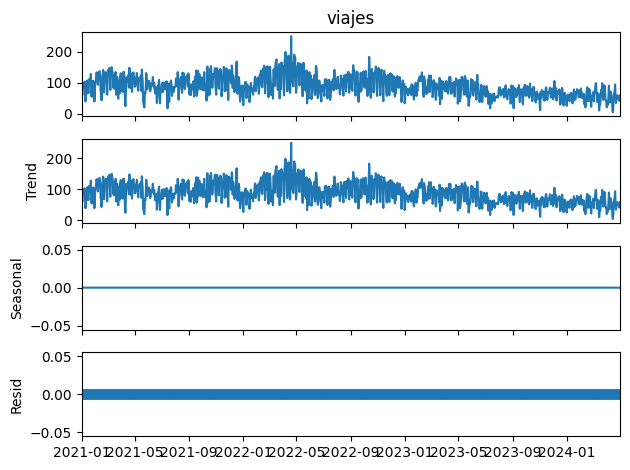

In [85]:
result = seasonal_decompose(df_ing['viajes'], period=1)
result.plot();

El grafico para seasonal es una linea lo cual indica que no se trata de una serie con temporadas

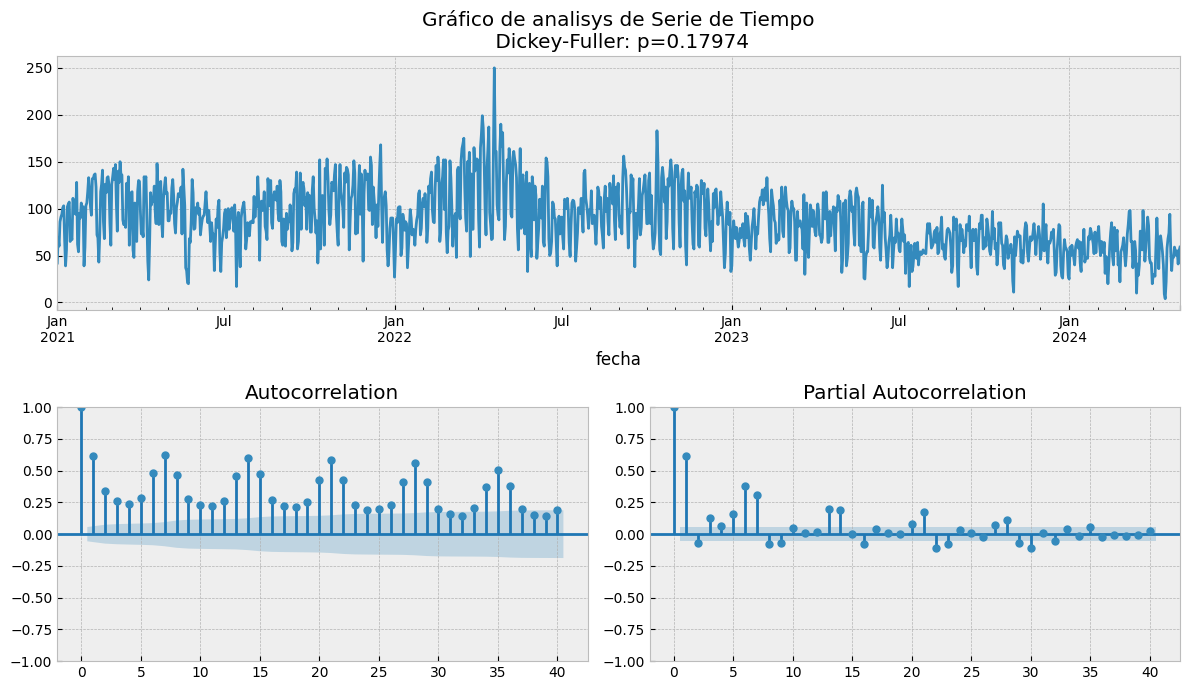

In [87]:
tsplot(df_ing['viajes'], lags = 40);

Diferenciar: El test de DF es de 0.17974, asi que se tendra que diferenciar la seria para transformarla en estacionaria

In [88]:
df_ing['viajes_diff'] = df_ing['viajes'].diff().dropna()
df_ing.dropna(inplace=True)

/tmp/ipykernel_2215/2062116121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ing['viajes_diff'] = df_ing['viajes'].diff().dropna()
/tmp/ipykernel_2215/2062116121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ing.dropna(inplace=True)


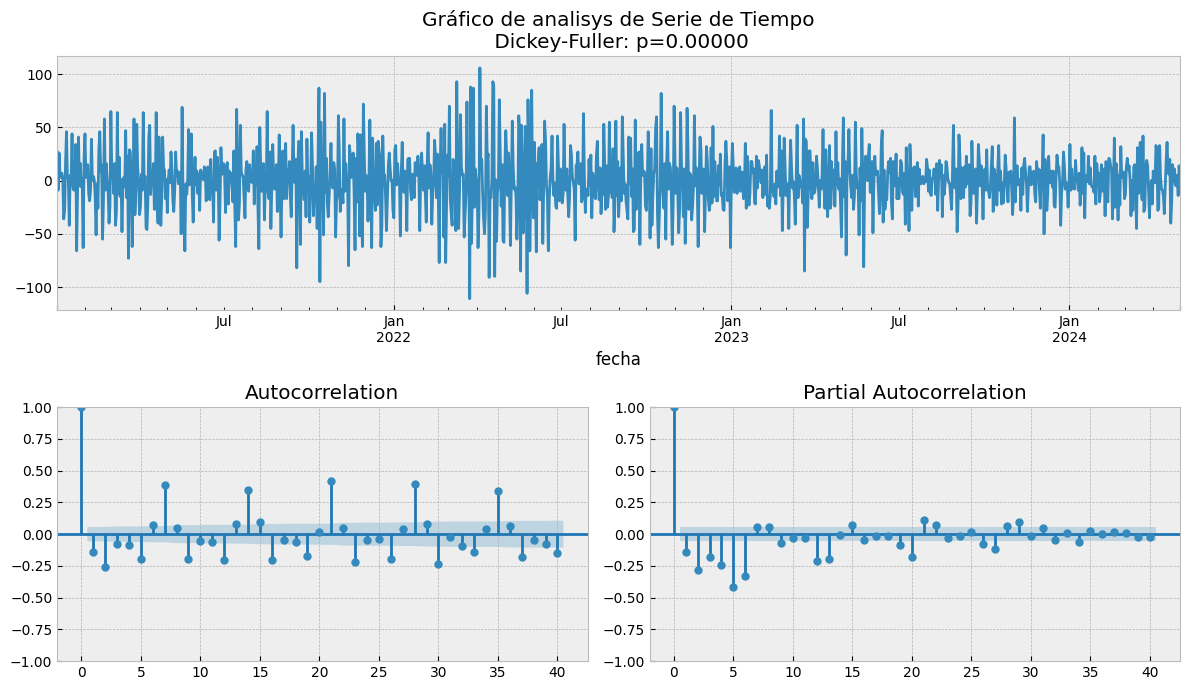

In [89]:
tsplot(df_ing['viajes_diff'], lags = 40);

Diferenciar: El test de DF es de 0.00000, con lo cual se concluye que con la diferenciacion de 1er orden, es suficiente para volver la serie estacionaria
AR: Los primeros 6 lags son significativos. Proponer en AutoArima un max de AR = 6
MA: Los 7 primeros lags son significativos y luego entra en un patron con frecuencia igual a 7 lags. Proponer en AutoArima un max de MA = 7

In [90]:
model_ing = auto_arima(df_ing['viajes'],
                       start_p=0,
                       d=1,
                       start_q=0,
                       test='adf',
                       max_p=6,
                       max_d=1,
                       max_q=7,
                       max_P=3,
                       max_D=1,
                       max_Q=3,
                       m=7, #Representa la periodicidad estacional de la serie
                       seasonal=False, #Esto le permite a auto_arima considerar modelos estacionales
                       trace=True, #Muestra en pantalla el proceso de búsqueda de modelos
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

/home/ge/.virtualenvs/general/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11596.778, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11575.667, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11413.247, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11594.778, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11225.069, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11157.334, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11475.632, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11149.858, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11437.126, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11111.018, Time=0.51 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=11365.057, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=11043.073, Time=0.77 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=11132.543, Time=0.36 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=10991.158, Time=1.91 sec
 ARIMA(6,1,0)(0,0,0

In [92]:
model_ing.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1215
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -5376.349
Date:                Thu, 12 Dec 2024   AIC                          10776.698
Time:                        23:56:06   BIC                          10837.918
Sample:                    01-02-2021   HQIC                         10799.746
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4093      0.144     -2.837      0.005      -0.692      -0.127
ar.L1          1.0744      0.045     24.103      0.000       0.987       1.162
ar.L2         -1.6548      0.035    -47.372      0.000      -1.723      -1.586
ar.L3          1.2066      0.061     19.620      0.000       1.086       1.327
ar.L4         -1.2049      0.036    -33.198      0.000      -1.276      -1.134
ar.L5          0.2809      0.041      6.896      0.000       0.201       0.361
ma.L1         -1.6123      0.035    -45.676      0.000      -1.682      -1.543
ma.L2          1.9785      0.044     44.626      0.000       1.892       2.065
ma.L3         -1.9377      0.042    -45.605      0.000      -2.021      -1.854
ma.L4          1.5191      0.041     37.384      0.000       1.439       1.599
ma.L5         -0.7779      0.030    -25.812      0.000      -0.837      -0.719
sigma2       460.9577     17.013     27.094      0.000     427.613     494.303
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):               252.16
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Ljung +++ poca correlacion entre los residuos
- JB --- los residuos no tienen distibucion normal
- H --- los residuos tienen varianza variable en el tiempo
- skew --- residuos no simetricos
- Kurtosis --- muchos residuos outliers 

### Plaza San Martin

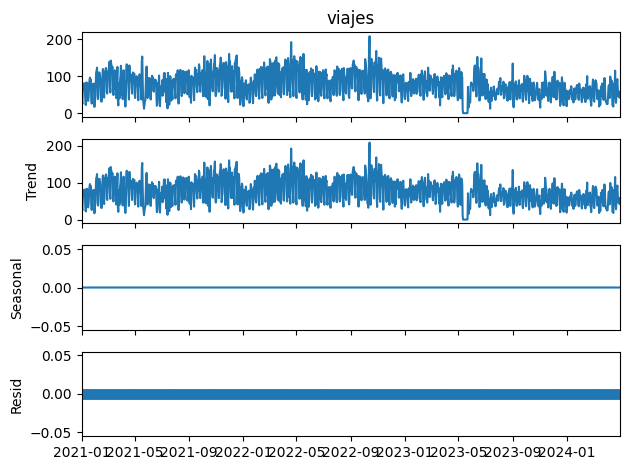

In [12]:
result = seasonal_decompose(df_martin['viajes'], period=1)
result.plot();

El grafico para seasonal es una linea lo cual indica que no se trata de una serie con temporadas

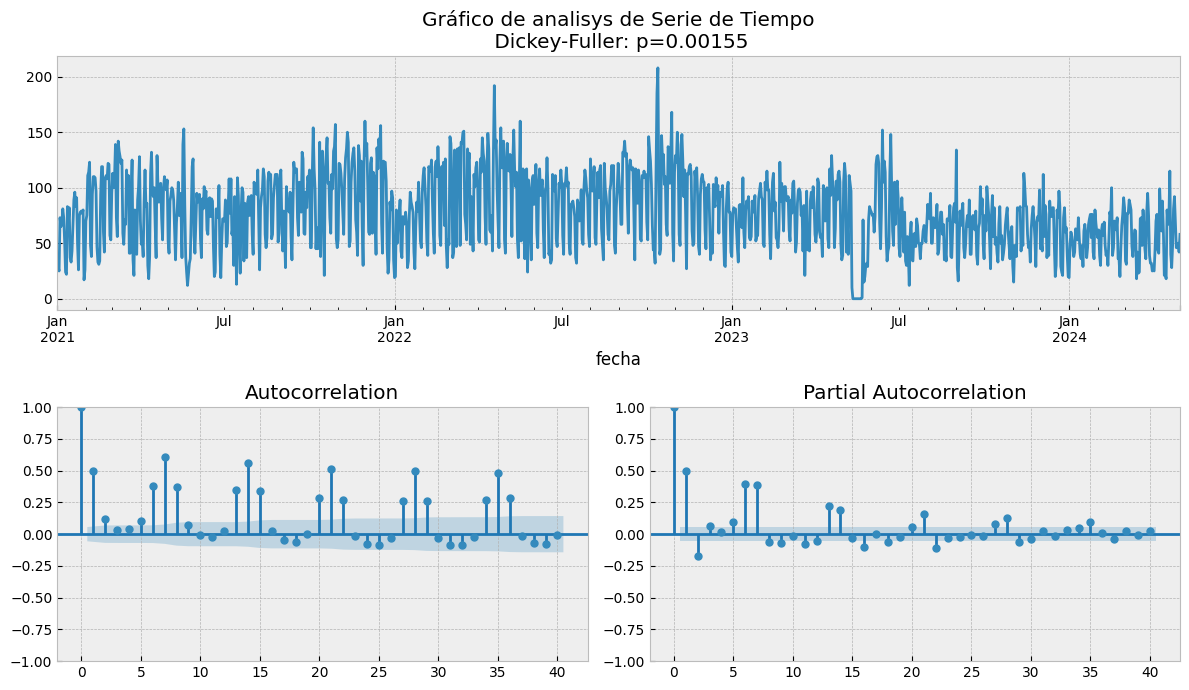

In [15]:
tsplot(df_martin['viajes'], lags = 40);

Diferenciar: El test de DF es de 0.00155 con lo cual se concluye que es una serie estacionaria
AR: Los primeros 6 lags son significativos. Proponer en AutoArima un max de AR = 6
MA: Los 7 primeros lags son significativos y luego entra en un patron con frecuencia igual a 7 lags. Proponer en AutoArima un max de MA = 7

In [20]:
model_martin = auto_arima(df_martin['viajes'],
                       start_p=0,
                       d=0,
                       start_q=0,
                       test='adf',
                       max_p=8,
                       max_d=1,
                       max_q=7,
                       max_P=3,
                       max_D=1,
                       max_Q=3,
                       m=7, #Representa la periodicidad estacional de la serie
                       seasonal=True, #Esto le permite a auto_arima considerar modelos estacionales
                       trace=True, #Muestra en pantalla el proceso de búsqueda de modelos
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=11588.689, Time=2.78 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=12001.133, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=11270.272, Time=1.04 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=11423.626, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14243.251, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=11661.949, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=11157.683, Time=6.20 sec
 ARIMA(1,0,0)(3,0,0)[7] intercept   : AIC=11094.189, Time=12.93 sec
 ARIMA(1,0,0)(3,0,1)[7] intercept   : AIC=inf, Time=15.02 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=11068.166, Time=13.17 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=10986.479, Time=2.73 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=11430.140, Time=0.93 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=11040.750, Time=11.66 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=11337.463, Time=4.36 sec
 ARIMA(1,0,0)(2,0,2)[

In [21]:
model_martin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1216
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 7)   Log Likelihood               -5473.182
Date:                             Fri, 13 Dec 2024   AIC                          10958.364
Time:                                     20:34:04   BIC                          10988.984
Sample:                                 01-01-2021   HQIC                         10969.891
                                      - 04-30-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3949      0.022     17.745      0.000       0.351       0.439
ar.L2          0.0896      0.024      3.669      0.000       0.042       0.138
ar.S.L7        1.0638      0.024     43.550      0.000       1.016       1.112
ar.S.L14      -0.0646      0.024     -2.653      0.008      -0.112      -0.017
ma.S.L7       -0.9288      0.013    -73.986      0.000      -0.953      -0.904
sigma2       466.8721     14.100     33.112      0.000     439.237     494.507
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               182.32
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.39
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model_martin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1216
Model:               SARIMAX(7, 0, 4)   Log Likelihood               -5555.748
Date:                Fri, 13 Dec 2024   AIC                          11135.496
Time:                        20:26:29   BIC                          11196.736
Sample:                    01-01-2021   HQIC                         11158.550
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2782      0.028     45.395      0.000       1.223       1.333
ar.L2         -1.5291      0.045    -34.302      0.000      -1.616      -1.442
ar.L3          1.4822      0.059     25.019      0.000       1.366       1.598
ar.L4         -1.1381      0.065    -17.574      0.000      -1.265      -1.011
ar.L5          0.5748      0.059      9.688      0.000       0.458       0.691
ar.L6          0.1026      0.045      2.284      0.022       0.015       0.191
ar.L7          0.2287      0.028      8.227      0.000       0.174       0.283
ma.L1         -0.7603      0.017    -44.176      0.000      -0.794      -0.727
ma.L2          1.3377      0.016     84.116      0.000       1.306       1.369
ma.L3         -0.7592      0.016    -47.561      0.000      -0.791      -0.728
ma.L4          0.9042      0.016     57.409      0.000       0.873       0.935
sigma2       573.5465     19.368     29.614      0.000     535.587     611.506
===================================================================================
Ljung-Box (L1) (Q):                   2.60   Jarque-Bera (JB):               120.68
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Ljung +++ poca correlacion entre los residuos
- JB --- los residuos no tienen distibucion normal
- H --- los residuos tienen varianza variable en el tiempo
- skew +++ residuos simetricos
- Kurtosis --- muchos residuos outliers 

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
modelo_final_martin = SARIMAX(df_martin['viajes'], order=(2, 0, 0), seasonal_order=(2, 0, 1, 7))
resultado_martin = modelo_final_martin.fit()


/home/ge/.virtualenvs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ge/.virtualenvs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.73489D+00    |proj g|=  1.38770D-01


 This problem is unconstrained.



At iterate    5    f=  4.66857D+00    |proj g|=  1.66083D-02

At iterate   10    f=  4.62331D+00    |proj g|=  9.37607D-02

At iterate   15    f=  4.51810D+00    |proj g|=  7.61312D-02

At iterate   20    f=  4.51029D+00    |proj g|=  2.48496D-03

At iterate   25    f=  4.50277D+00    |proj g|=  7.95237D-03

At iterate   30    f=  4.50098D+00    |proj g|=  1.26976D-03

At iterate   35    f=  4.50097D+00    |proj g|=  5.06394D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     47      1     0     0   3.056D-06   4.501D+00
  F =   4.5009721361403265     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

<Axes: xlabel='fecha'>

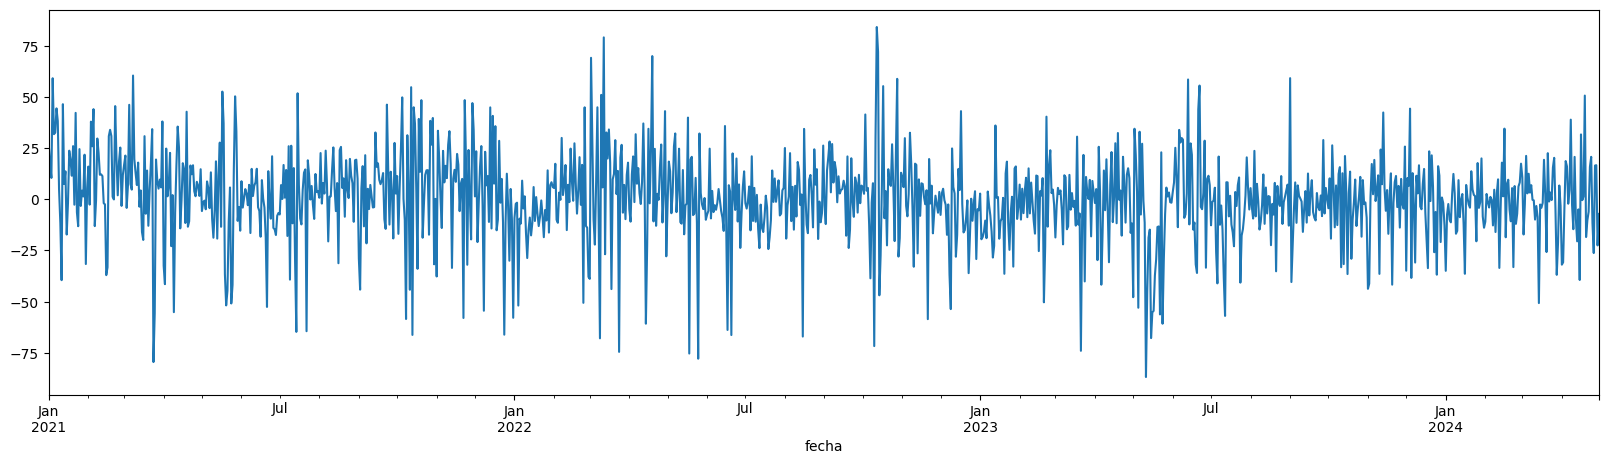

In [27]:
resultado_martin.resid.plot(figsize=(20,5))

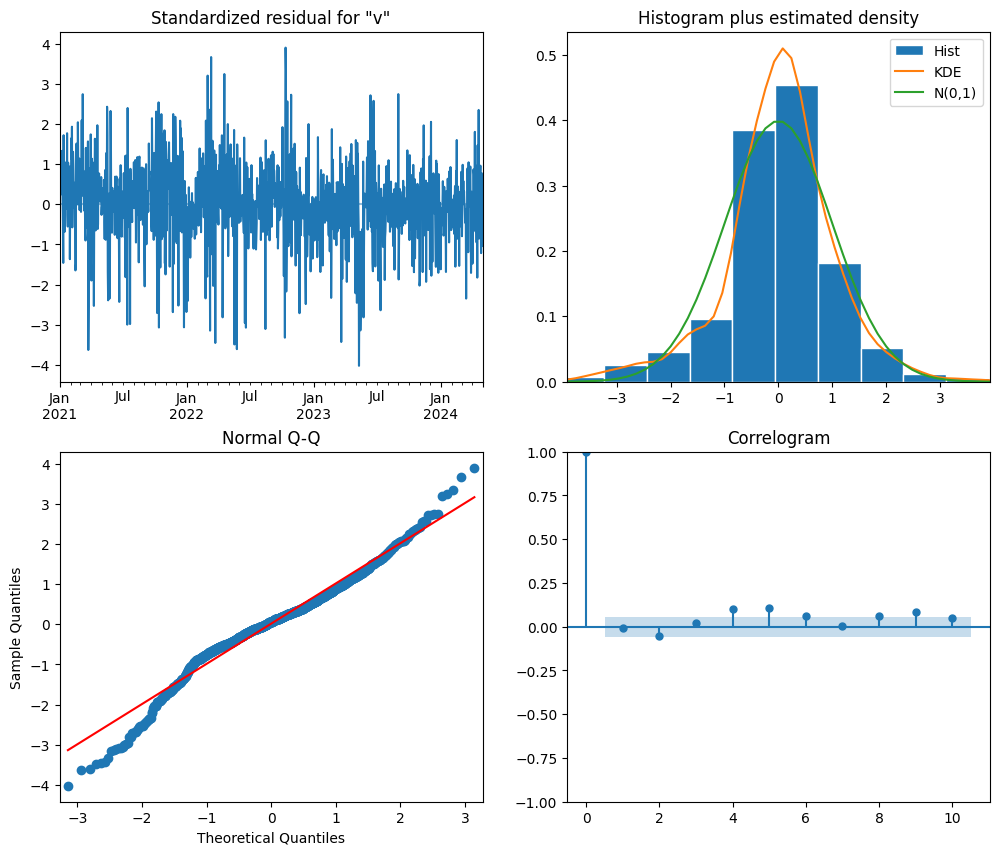

In [28]:
fig_res_2 = resultado_martin.plot_diagnostics(figsize=(12,10))

### Ciudad Universitaria I

### Ciudad Universitaria II